## Alunos

> - Andreus Jartã Timm
> - Kesley Jorge dos Santos
> - Priscila Alvez Costa

# Estudo de Séries Temporais

# 1. Importação das Bibliotecas

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from pmdarima.arima.utils import ndiffs
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 2 Carregando o Dataset

In [184]:
elnino_data = sm.datasets.elnino.load_pandas().data

elnino_data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30


In [185]:
# Transformar os dados para ter uma coluna de 'Mes' e uma coluna de 'Temperatura'
elnino_series = elnino_data.melt(id_vars=['YEAR'], var_name='Mes', value_name='Temperatura')

# Mapear os nomes dos meses para números
month_mapping = {
    "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04", "MAY": "05", "JUN": "06",
    "JUL": "07", "AUG": "08", "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"
}
elnino_series['Mes_Num'] = elnino_series['Mes'].map(month_mapping)

# Criar a coluna 'Ano_Mes' com o formato 'YYYY-MM'
elnino_series['Ano_Mes'] = elnino_series['YEAR'].astype(int).astype(str) + '-' + elnino_series['Mes_Num']

# Ordenar os dados por 'Ano_Mes'
elnino_series = elnino_series.sort_values(by='Ano_Mes')

# Manter apenas as colunas 'Ano_Mes' e 'Temperatura'
elnino_series = elnino_series[['Ano_Mes', 'Temperatura']]

In [186]:
elnino_series.head()

,Ano_Mes,Temperatura
0,1950-01,23.11
61,1950-02,24.20
122,1950-03,25.37
183,1950-04,23.86
244,1950-05,23.03


In [187]:
elnino_series['Ano_Mes'] = pd.to_datetime(elnino_series['Ano_Mes'], format='%Y-%m')

In [188]:
elnino_series.head()

,Ano_Mes,Temperatura
0,1950-01-01,23.11
61,1950-02-01,24.20
122,1950-03-01,25.37
183,1950-04-01,23.86
244,1950-05-01,23.03


In [189]:
elnino_series.tail()

,Ano_Mes,Temperatura
487,2010-08-01,19.49
548,2010-09-01,19.28
609,2010-10-01,19.73
670,2010-11-01,20.44
731,2010-12-01,22.07


In [190]:
# Definindo o Índice
elnino_series.set_index('Ano_Mes', inplace=True)

# 3. Exploração e visualização inicial

Resumo Estatístico:
       Temperatura
count   732.000000
mean     23.092623
std       2.245903
min      18.950000
25%      21.250000
50%      22.855000
75%      24.952500
max      29.240000


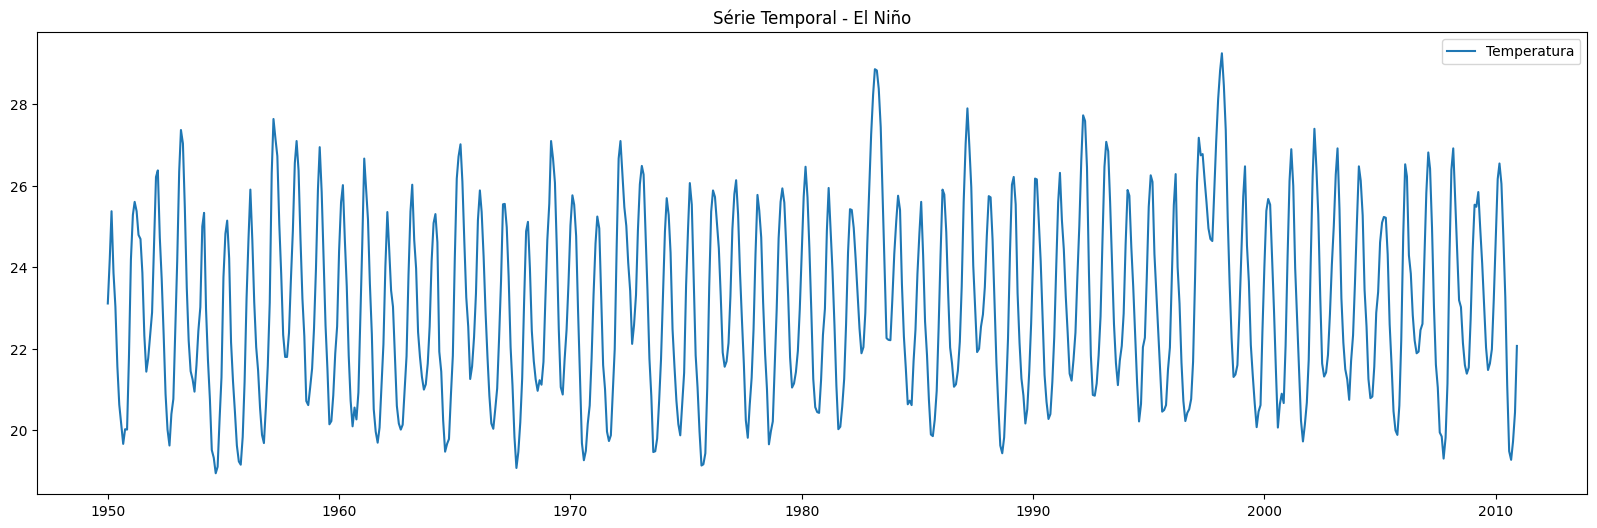

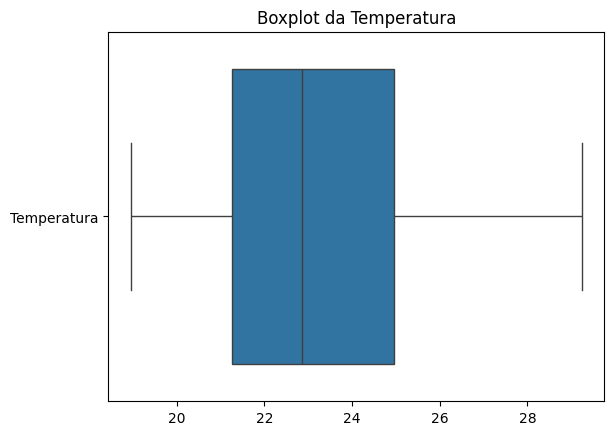

In [272]:
print("Resumo Estatístico:")
print(elnino_series.describe())
plt.figure(figsize=(20, 6))
plt.plot(elnino_series, label='Temperatura')
plt.title('Série Temporal - El Niño')
plt.legend()
plt.show()

sns.boxplot(data=elnino_series, orient='h')
plt.title("Boxplot da Temperatura")
plt.show()

# 4. Análise de normalidade

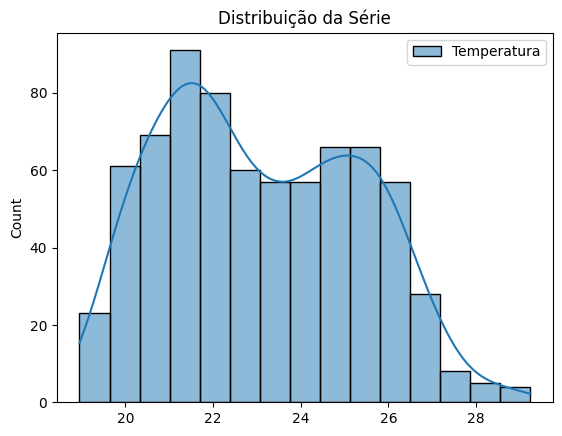

In [192]:
sns.histplot(elnino_series, kde=True, bins=15)
plt.title("Distribuição da Série")
plt.show()

### QQ plot

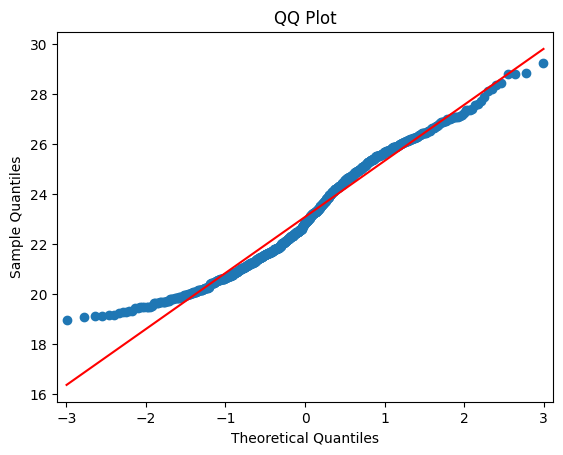

In [193]:
sm.qqplot(elnino_series['Temperatura'], line='s')
plt.title("QQ Plot")
plt.show()

Os dados não seguem perfeitamente uma distribuição normal, principalmente devido à assimetria na cauda inferior. A parte central dos dados se aproxima de uma normal.

# 5. Análise de estacionariedade

### Teste KPSS

In [194]:
kpss_stat, p_value, lags, critical_values = kpss(elnino_series)
print('Teste KPSS:')
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
print('Valores Críticos:')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')
print('Resultado:')
if p_value > 0.05:
    print("Falha ao rejeitar a hipótese nula: Os dados são estacionários.")
else:
    print("Rejeitamos a hipótese nula: Os dados não são estacionários.")

Teste KPSS:
Estatística do teste: 0.3939
p-valor: 0.0798
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390
Resultado:
Falha ao rejeitar a hipótese nula: Os dados são estacionários.


### Teste ADF

In [195]:
adf_result = adfuller(elnino_series['Temperatura'])
print('Teste ADF:')
print(f'Estatística do teste: {adf_result[0]:.4f}')
print(f'p-valor: {adf_result[1]:.4f}')
print('Resultado:')
if adf_result[1] > 0.05:
    print("Falha ao rejeitar a hipótese nula: Os dados não são estacionários.")
else:
    print("Rejeitamos a hipótese nula: Os dados são estacionários.")

Teste ADF:
Estatística do teste: -5.6932
p-valor: 0.0000
Resultado:
Rejeitamos a hipótese nula: Os dados são estacionários.


In [196]:
def plot_acf_pacf(series, lags=100, title=''):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes[0].plot(series)
    axes[0].set_title(f'Série Temporal - {title}')
    plot_acf(series, lags=lags, ax=axes[1])
    plot_pacf(series, lags=lags, ax=axes[2])
    plt.tight_layout()
    plt.show()
    

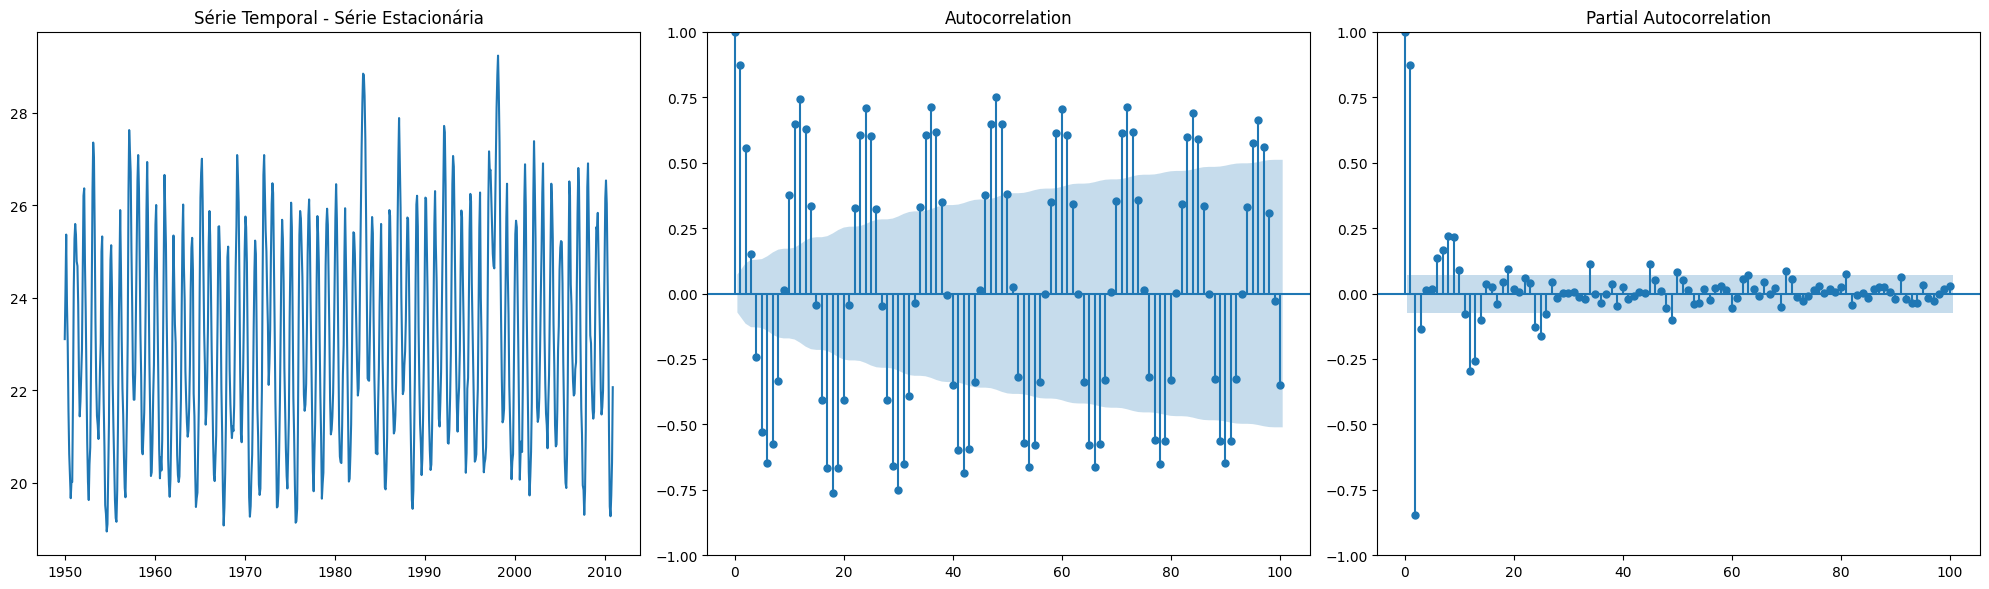

In [197]:
plot_acf_pacf(elnino_series, title='Série Estacionária')

# 6. Decomposição da série temporal

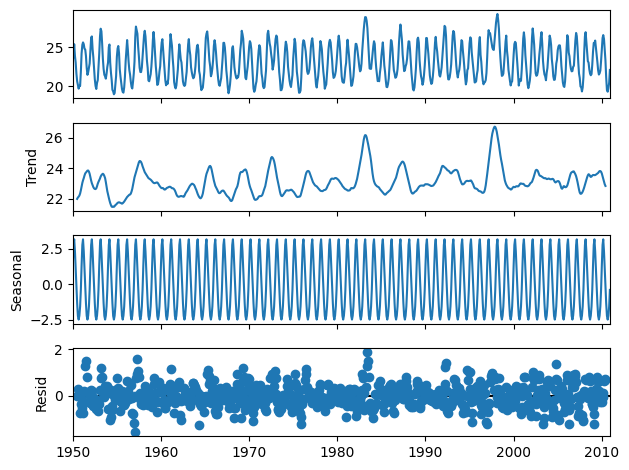

In [198]:
decomposition = seasonal_decompose(elnino_series, model='additive', period=12)
decomposition.plot()
plt.show()

# 7. ACF e PACF

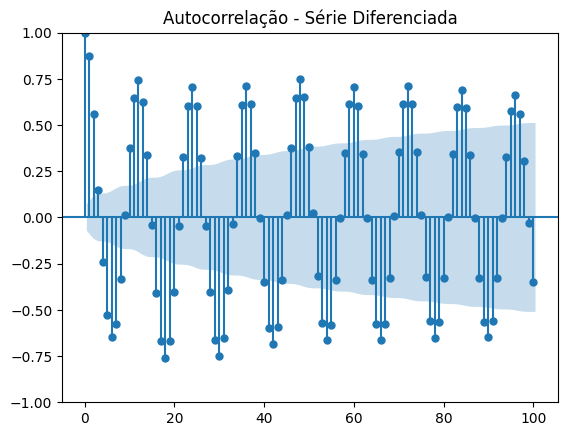

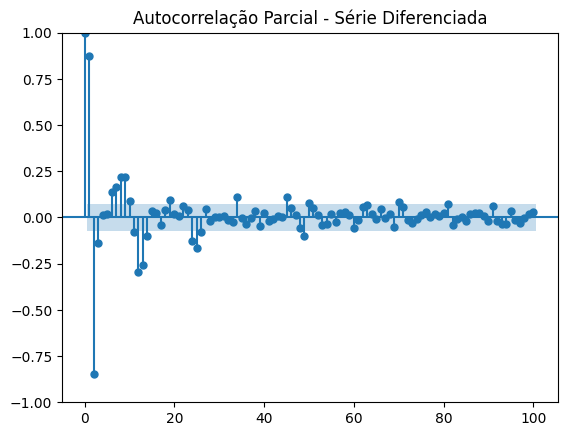

In [199]:
plot_acf(elnino_series, lags=100)
plt.title("Autocorrelação - Série Diferenciada")
plt.show()

plot_pacf(elnino_series, lags=100)
plt.title("Autocorrelação Parcial - Série Diferenciada")
plt.show()

# 8. Seleção do modelo testando várias configurações

In [203]:
# Função para testar os modelos
def test_models(series):
    best_score = np.inf
    best_order = None
    best_model = None

    # Testar modelos AR (p)
                
    # Testar modelos ARIMA (p, d, q)
    for p in range(0, 4):  # Testando ordens de p para ARIMA
        for d in range(0, 2):  # Testando ordens de d para ARIMA
            for q in range(0, 4):  # Testando ordens de q para ARIMA
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    prediction = model.predict(start=0, end=len(series)-1)
                    mse = mean_squared_error(series, prediction)
                    if mse < best_score:
                        best_score = mse
                        best_order = f'ARIMA({p},{d},{q})'
                        best_model = model
                    print(f'ARIMA({p},{d},{q}), MSE={mse}')
                except Exception as e:
                    print(f'Erro no modelo ARIMA({p},{d},{q}): {e}')
    
    # Testar modelos SARIMA (p, d, q, P, D, Q, m)
    for p in range(1, 3):  # Testando ordens de p para SARIMA
        for d in range(1, 2):  # Testando ordens de d para SARIMA
            for q in range(1, 3):  # Testando ordens de q para SARIMA
                for P in range(1, 2):  # Testando ordens de P sazonal
                    for D in range(1, 2):  # Testando ordens de D sazonal
                        for Q in range(1, 2):  # Testando ordens de Q sazonal
                            for m in [12]:  # Frequência sazonal, por exemplo, m=12 para dados mensais
                                try:
                                    model = SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit(disp=False)
                                    prediction = model.predict(start=0, end=len(series)-1)
                                    mse = mean_squared_error(series, prediction)
                                    if mse < best_score:
                                        best_score = mse
                                        best_order = f'SARIMA({p},{d},{q},{P},{D},{Q},{m})'
                                        best_model = model
                                    print(f'SARIMA({p},{d},{q},{P},{D},{Q},{m}), MSE={mse}')
                                except Exception as e:
                                    print(f'Erro no modelo SARIMA({p},{d},{q},{P},{D},{Q},{m}): {e}')
    
    print(f'\nMelhor modelo: {best_order} com MSE de {best_score}')
    return best_model

# Testar os modelos
best_model = test_models(elnino_series['Temperatura'])

ARIMA(0,0,0), MSE=5.037188475345282
ARIMA(0,0,1), MSE=1.6874308190325185
ARIMA(0,0,2), MSE=0.8281392469398016
ARIMA(0,0,3), MSE=0.5822128398584056
ARIMA(0,1,0), MSE=2.0186681693991813
ARIMA(0,1,1), MSE=1.4609618120362464
ARIMA(0,1,2), MSE=1.3002729120605403
ARIMA(0,1,3), MSE=1.2626669256622463
ARIMA(1,0,0), MSE=1.2067566376231647
ARIMA(1,0,1), MSE=0.6662552822377683
ARIMA(1,0,2), MSE=0.5017717776126074
ARIMA(1,0,3), MSE=0.452984186640802
ARIMA(1,1,0), MSE=1.3359300942187025
ARIMA(1,1,1), MSE=1.2959471751420264
ARIMA(1,1,2), MSE=1.2603428814779158
ARIMA(1,1,3), MSE=1.2528267165891804
ARIMA(2,0,0), MSE=0.34199742845029457
ARIMA(2,0,1), MSE=0.3355464333069177
ARIMA(2,0,2), MSE=0.3348134815142633
ARIMA(2,0,3), MSE=0.33435924642956905
ARIMA(2,1,0), MSE=1.258977368666411
ARIMA(2,1,1), MSE=1.0750240739406116
ARIMA(2,1,2), MSE=1.009889016332304
ARIMA(2,1,3), MSE=0.9933823520689907
ARIMA(3,0,0), MSE=0.3350088439714848
ARIMA(3,0,1), MSE=0.33489513954953914
ARIMA(3,0,2), MSE=0.279514174868507
ARI

O melhor modelo encontrado foi o ARIMA(3, 0, 3) com MSE de 0.2631702245190908

In [247]:
# Ajustar o modelo ARIMA
model = ARIMA(elnino_series['Temperatura'], order=(3, 0, 3)).fit()

In [248]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            Temperatura   No. Observations:                  732
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -548.229
Date:                Sat, 11 Jan 2025   AIC                           1112.459
Time:                        22:03:46   BIC                           1149.225
Sample:                    01-01-1950   HQIC                          1126.641
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.9125      4.564      5.020      0.000      13.967      31.858
ar.L1          2.7267      0.009    293.675      0.000       2.708       2.745
ar.L2         -2.7227      0.016   -169.335      0.0

O modelo esta capturando a dinâmica da série temporal de forma eficaz.

## Visualização das previsões

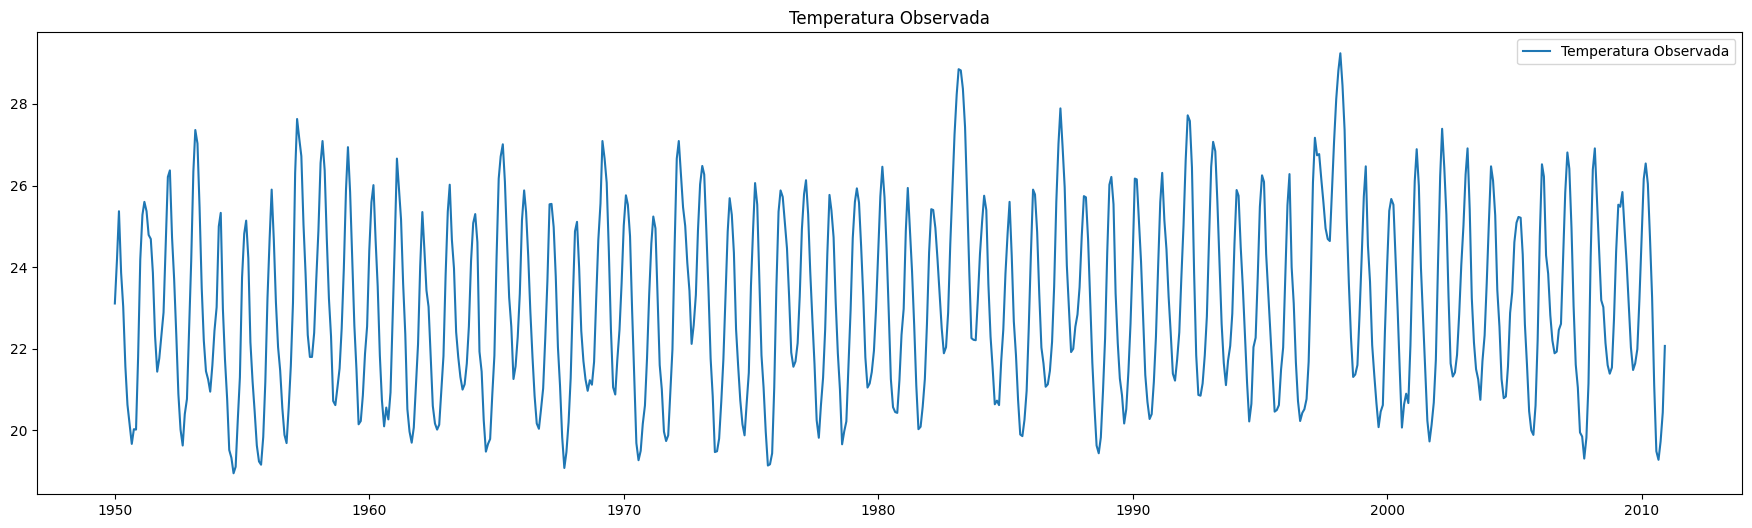

In [249]:
plt.figure(figsize=(22, 6))
plt.plot(elnino_series['Temperatura'], label='Temperatura Observada')
plt.legend()
plt.title('Temperatura Observada')
plt.show()

Média dos resíduos ao quadrado: 0.2631702245190908


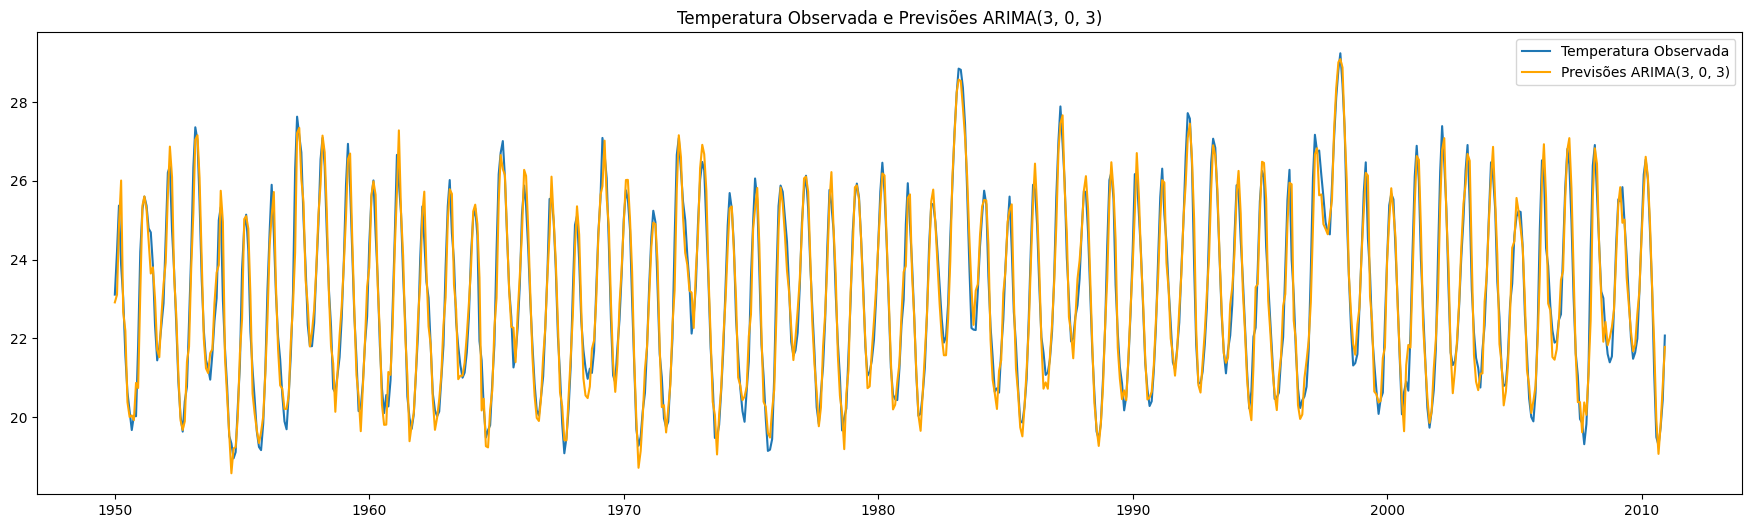

In [250]:
# Ajustar o modelo ARIMA
model = ARIMA(elnino_series['Temperatura'], order=(3, 0, 3)).fit()

# Calcular a média dos resíduos ao quadrado
mean_squared_resid = (model.resid ** 2).mean()
print(f'Média dos resíduos ao quadrado: {mean_squared_resid}')

plt.figure(figsize=(22, 6))
plt.plot(elnino_series['Temperatura'], label='Temperatura Observada')
plt.plot(model.predict(), label='Previsões ARIMA(3, 0, 3)', color='orange')
plt.legend()
plt.title('Temperatura Observada e Previsões ARIMA(3, 0, 3)')
plt.show()

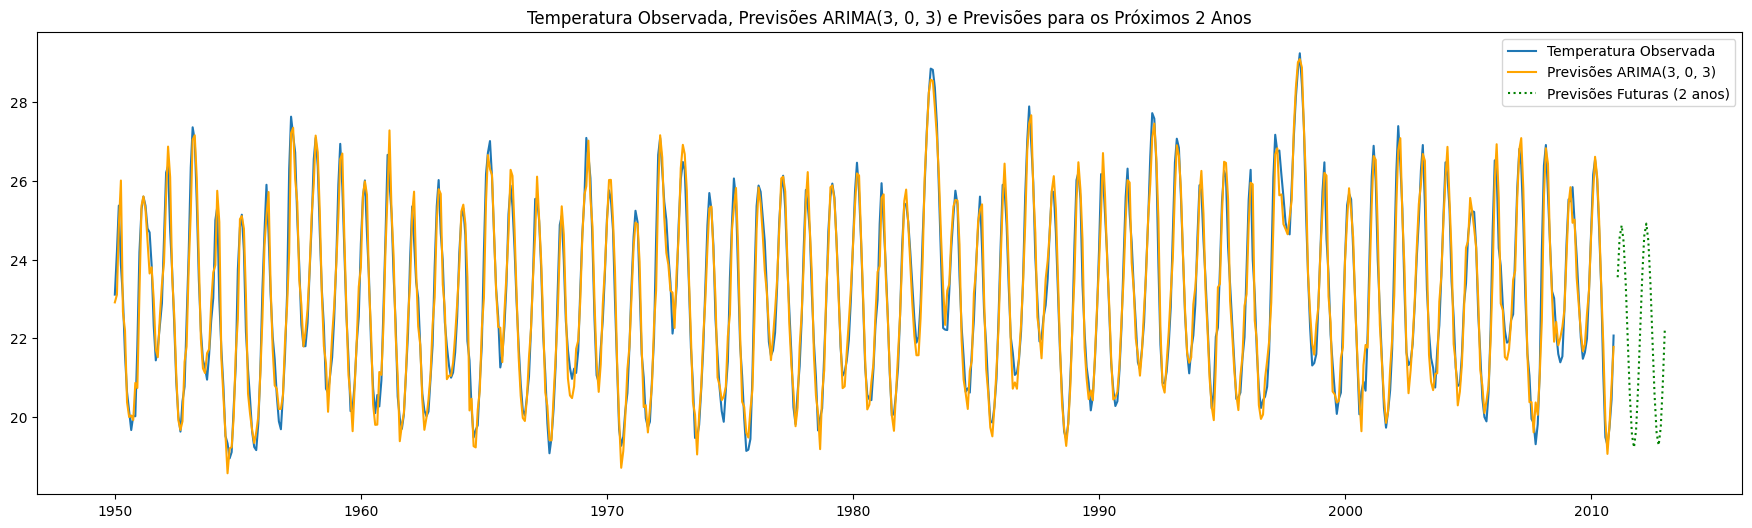

In [270]:
# Número de períodos futuros para prever (10 anos, assumindo dados mensais)
future_periods = 24  # 2 anos de previsões mensais

# Gerar as previsões futuras
forecast = model.forecast(steps=future_periods)

# Criar um índice de datas para os próximos 10 anos (assumindo mensalidade)
last_date = elnino_series.index[-1]
forecast_index = pd.date_range(start=last_date, periods=future_periods + 1, freq='M')[1:]

# Plotar os dados originais e as previsões
plt.figure(figsize=(22, 6))
plt.plot(elnino_series['Temperatura'], label='Temperatura Observada')
plt.plot(model.predict(), label='Previsões ARIMA(3, 0, 3)', color='orange')
plt.plot(forecast_index, forecast, label='Previsões Futuras (2 anos)', color='green', linestyle='dotted')
plt.legend()
plt.title('Temperatura Observada, Previsões ARIMA(3, 0, 3) e Previsões para os Próximos 2 Anos')
plt.show()

# 10. Diagnóstico do modelo

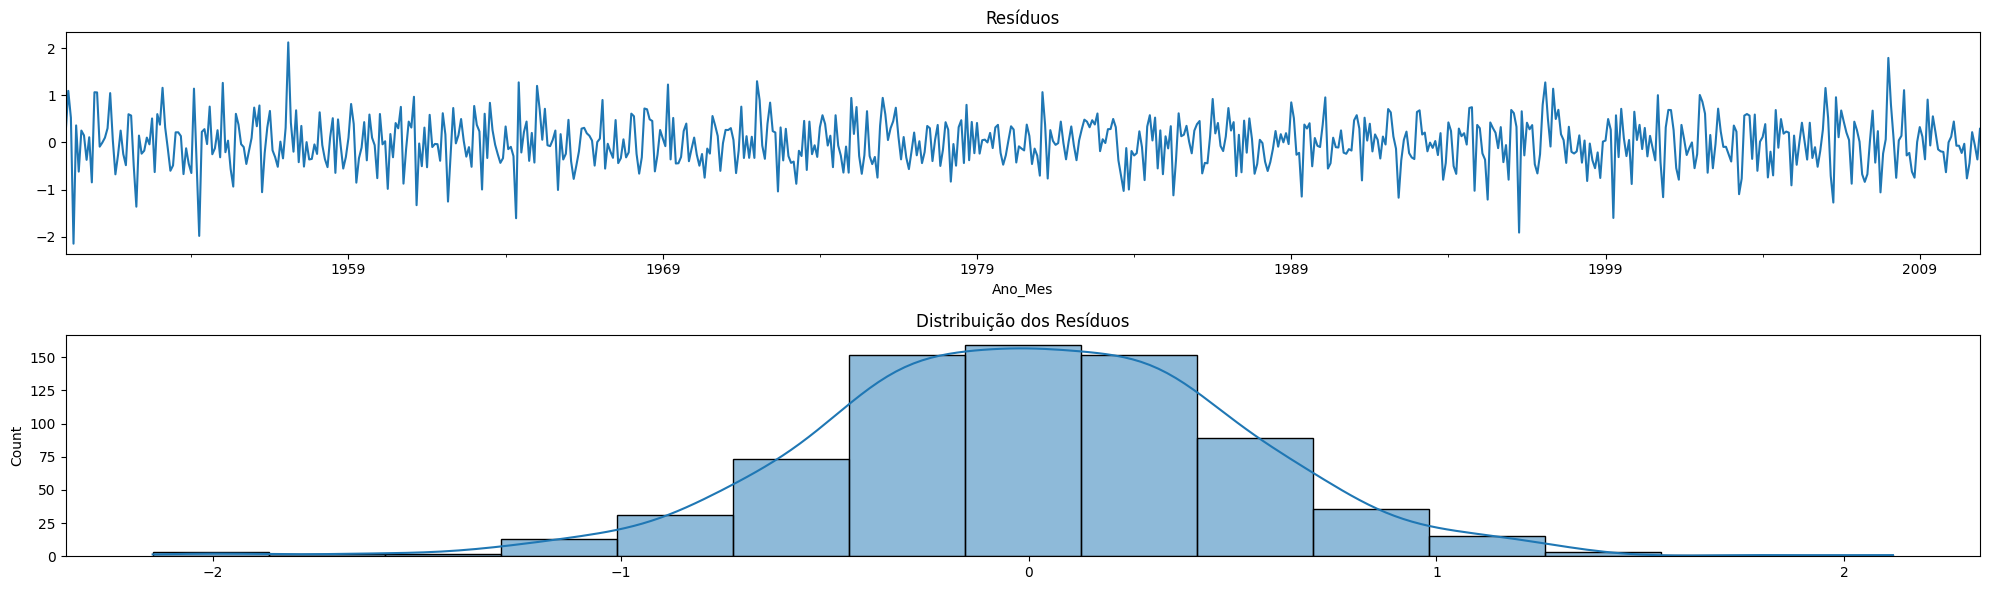

In [262]:
# Obter os resíduos do modelo
residuals = pd.Series(model.resid)

# Plotando os resíduos
plt.figure(figsize=(20, 6))
plt.subplot(211)
residuals.plot(title="Resíduos")
plt.subplot(212)
sns.histplot(residuals, kde=True, bins=15)
plt.title("Distribuição dos Resíduos")
plt.tight_layout()
plt.show()


A combinação dos dois gráficos sugere fortemente que o modelo que gerou esses resíduos tem um bom desempenho.

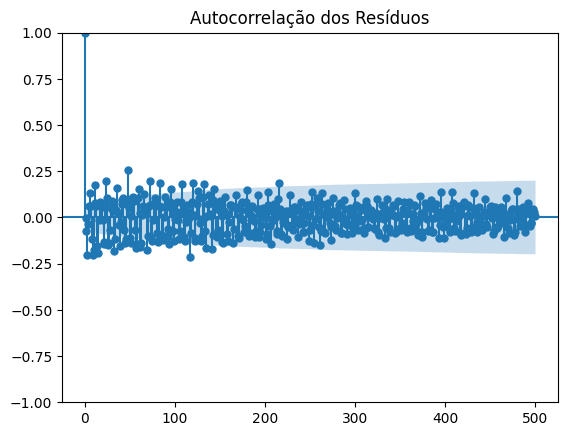

In [267]:
plot_acf(residuals, lags=500)

plt.title("Autocorrelação dos Resíduos")
plt.show()